In [1]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import networkx as nx
import osmnx as ox
ox.__version__
import matplotlib.pyplot as plt

Downloading and modelling the road network of New Delhi, India.

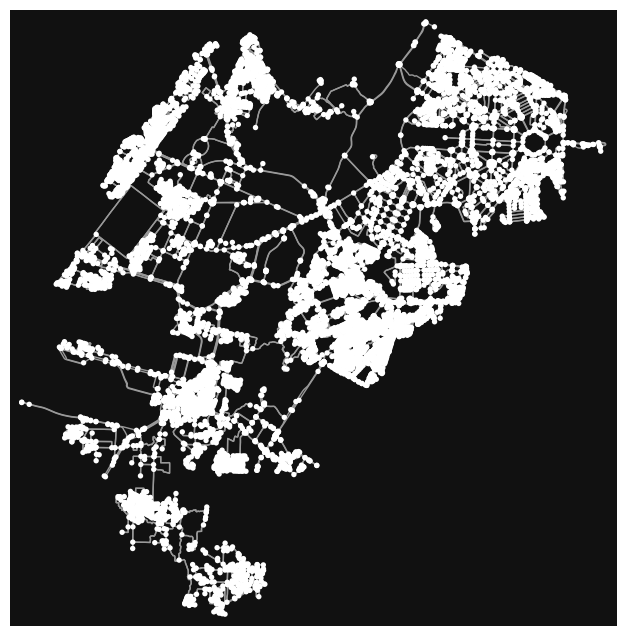

In [3]:
G = ox.graph_from_place("New Delhi, Delhi, India", network_type="drive")
fig, ax = ox.plot_graph(G)

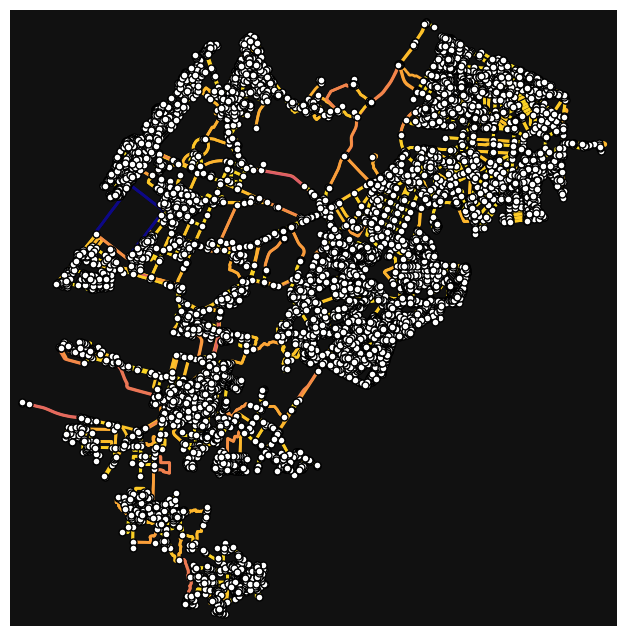

In [ ]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=25, edge_color=ec, edge_linewidth=2
)

In [ ]:
# # find the shortest path (by distance) between these nodes then plot it
# orig = list(G)[670]
# dest = list(G)[2240]
# route = ox.shortest_path(G, orig, dest, weight="length")
# fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

In [ ]:
# # network from address, including only nodes within 4km along the network from the address
# G1 = ox.graph_from_address(
#     address="Rajiv Chowk, Connaught Place, Chanakya Puri Tehsil, New Delhi, Delhi, 110001, India",
#     dist=4000,
#     dist_type="network",
#     network_type="drive",
# )
# fig, ax = ox.plot_graph(G1)

In [ ]:
# # find the shortest path (by distance) between these nodes then plot it
# orig = list(G1)[67]
# dest = list(G1)[224]
# route = ox.shortest_path(G1, orig, dest, weight="length")

# # Calculate the total length of the path
# total_length = sum(ox.utils_graph.get_route_edge_attributes(G1, route, attribute="length"))

# print(f"Total length of the shortest path: {total_length} meters")

# # plot the path
# fig, ax = ox.plot_graph_route(G1, route, route_color="y", route_linewidth=6, node_size=0)

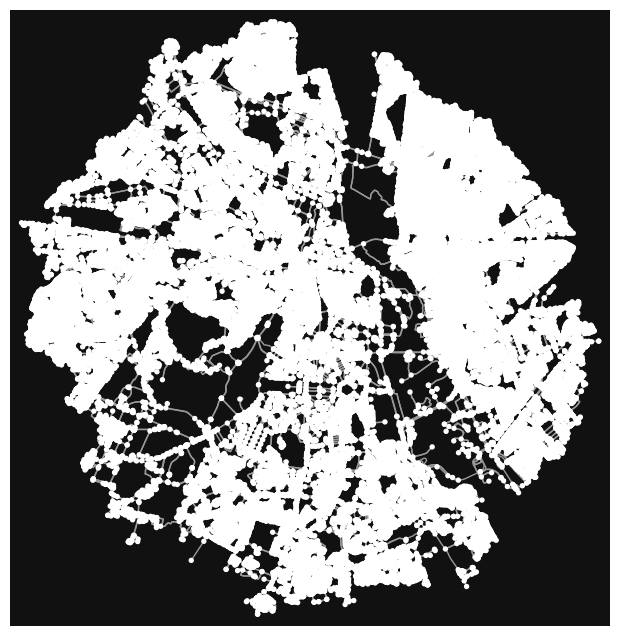

In [4]:
# network from address, including only nodes within 10km along the network from the address
G = ox.graph_from_address(
    address="New Delhi Railway Station, Central Delhi District, Delhi, 110001, India",
    dist=15000,
    dist_type="network",
    network_type="drive",
)
fig, ax = ox.plot_graph(G)

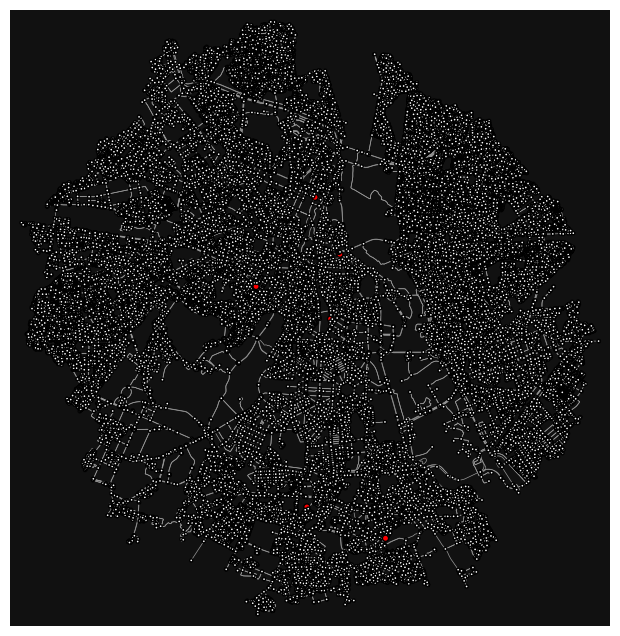

In [5]:
# convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.columns = gdf_edges.columns.str.lower()

# Locations to find
locations = {
    "Delhi University": (28.690956714654007, 77.2172266919105),
    "AIIMS Hospital": (28.56605868580513, 77.21120586861386),
    "Karol Bagh": (28.655110850607876, 77.18894406534763),
    "Kashmere Gate": (28.668587063940173, 77.22803556304746),
    "NDLS Railway Station": (28.64198133410332, 77.2219675483505),
    "Nehru Place": (28.550644879573245, 77.250201462446)
}

# Create a dictionary to store node sizes and colors
node_sizes = {node: 5 for node in G.nodes}  # Default node size for all nodes
node_colors = {node: 'w' for node in G.nodes}  # Default node color for all nodes

# Create a dictionary to store the nearest nodes for each location
location_nodes = {}

# Find and highlight the nodes for each location with a larger size and red color
for location, coords in locations.items():
    node = ox.distance.nearest_nodes(G, coords[1], coords[0])
    node_sizes[node] = 20  # Larger size for highlighted nodes
    node_colors[node] = 'r'  # Red color for highlighted nodes
    location_nodes[location] = node  # Store the nearest node for the location

# Plot the graph with the highlighted nodes
fig, ax = ox.plot_graph(G, node_color=list(node_colors.values()), node_edgecolor='k', node_size=list(node_sizes.values()), edge_linewidth=0.5)

In [6]:
# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G.nodes[u]['y'], G.nodes[u]['x'], G.nodes[v]['y'], G.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
alpha = sum(distances.values())
print(f"Sum of distances: {alpha} meters")

# Plot the routes
for route in shortest_paths.values():
    fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)


Output hidden; open in https://colab.research.google.com to view.

Number of edges corresponding to road filter: 474


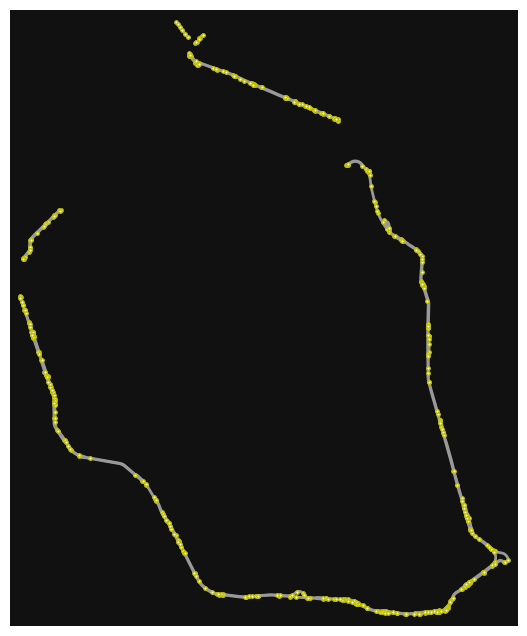

In [7]:
# List of road names to filter
road_names = ['Mahatma Gandhi Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)


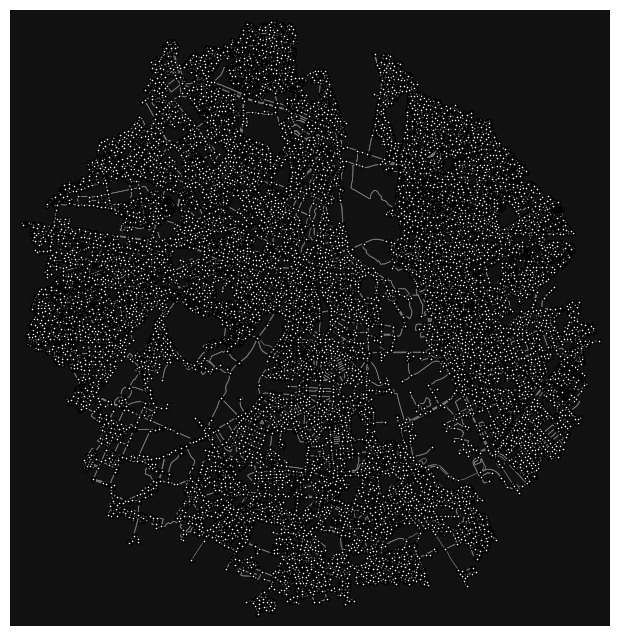

In [8]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Mahatma Gandhi Marg']

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Plot the filtered graph with adjusted edge parameters
fig, ax = ox.plot_graph(G_filtered, node_color='w', node_edgecolor='k', node_size=5, edge_color='gray', edge_linewidth=0.5)

In [9]:
# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Plot the routes
# for route in shortest_paths.values():
    # fig, ax = ox.plot_graph_route(G_filtered, route, route_color="y", route_linewidth=6, node_size=0)

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

In [10]:
# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Road Vulnerability Index (RVI): 4.726687839434384 %


Number of edges corresponding to road filter: 39


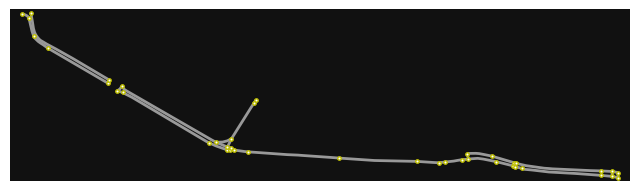

In [12]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Jawaharlal Nehru Marg', 'Jawaharlal Nehru Road']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [13]:
# Repeat for Jawaharlal Nehru Marg

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

Number of edges corresponding to road filter: 102


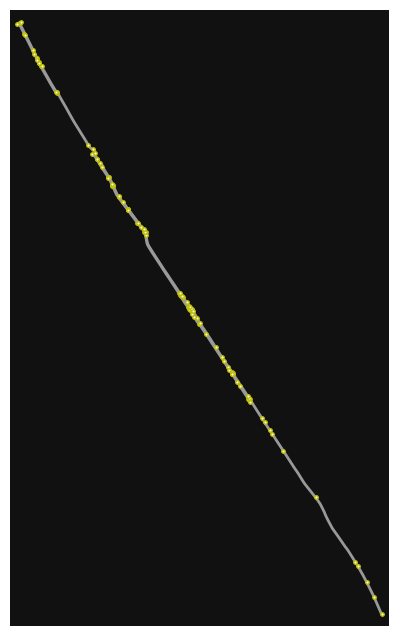

In [14]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Mathura Road', 'Dr. Zakir Hussain Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [15]:
# Repeat for Mathura Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

In [16]:
# Get the total number of nodes and edges in the graph
num_nodes = len(G.nodes)
num_edges = len(G.edges)

# Print the total number of nodes and edges
print(f"Total number of nodes: {num_nodes}")
print(f"Total number of edges: {num_edges}")

Total number of nodes: 81982
Total number of edges: 222218


Number of edges corresponding to road filter: 32


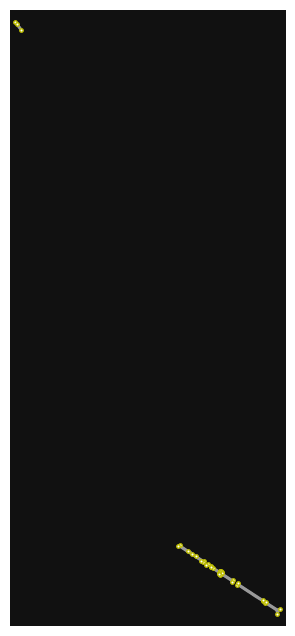

In [17]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Ashoka Road', 'Ashoka Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [18]:
# Repeat for Ashoka Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

Number of edges corresponding to road filter: 44


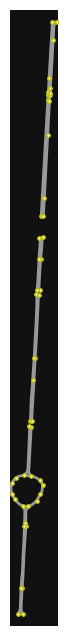

In [19]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Janpath', 'Motilal Nehru Place']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [20]:
# Repeat for Janpath Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

Number of edges corresponding to road filter: 15


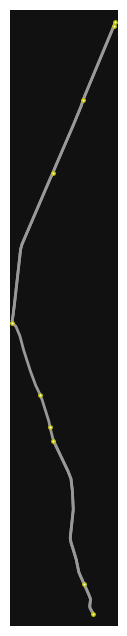

In [21]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Vishwavidyalaya Road', 'Acharya Sushil Marg', 'Chaubhurja Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [22]:
# Repeat for  Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 10713708180, 2958094339, 6362190795, 2958094340, 10280095505, 2958094336, 10280095501, 10815867628, 9870170213, 6754944635, 6754944660, 4231889750, 9871480986, 9901232345, 11849711922, 4231908351, 4231889735, 4231889730, 10564632115, 9181797243, 10595539489, 2971755130, 9181797234, 7220984773, 9880300263, 915436677, 915433980, 915432324, 915436686, 9868023622, 9868023624, 915436757, 5777854539, 5777854537, 6660513479, 6660530015, 9882537726, 9181797162, 9838197066, 9838197065, 10996948403, 9869669798, 10996948400, 4231714004, 9869618704, 6393695911, 4227901538, 11283069438, 11283069442, 11283069441, 9794868264, 10996946687, 9794868267, 4227901528, 943749488, 6720363046, 4227901527, 561316976, 6720363039, 6720363014, 6720363011, 9873780758, 9873780759, 9873780773, 9873780774, 9874283586, 6720362995, 9874283585, 9874283584, 6720350065, 6965585184, 6720350047, 249783313, 249783316, 267198392, 267198394, 939091095, 1869716

Number of edges corresponding to road filter: 134


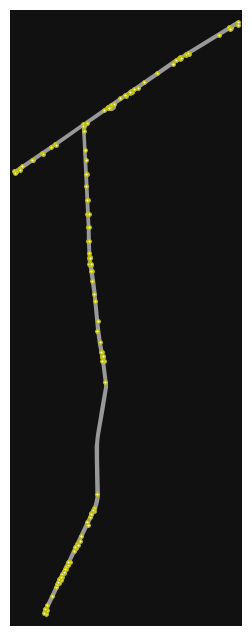

In [23]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Maharishi Raman Marg', 'Bhishma Pitamah Marg', 'Subramaniyam Bharti Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [24]:
# Repeat for  Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

Number of edges corresponding to road filter: 73


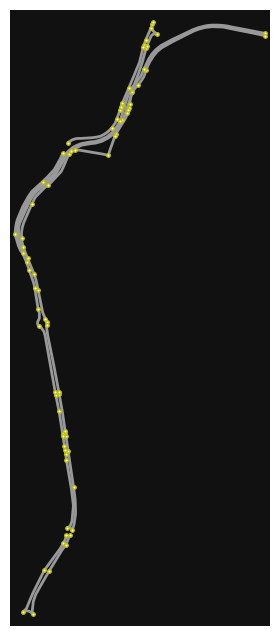

In [25]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Rani Jhansi Flyover', 'Rani Jhansi Road']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [26]:
# Repeat for  Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

Number of edges corresponding to road filter: 62


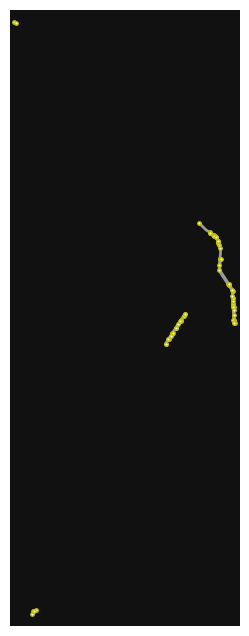

In [27]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Netaji Subhash Marg', 'Lothiyan Road', 'Vivekanand Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [28]:
# Repeat for  Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

Number of edges corresponding to road filter: 115


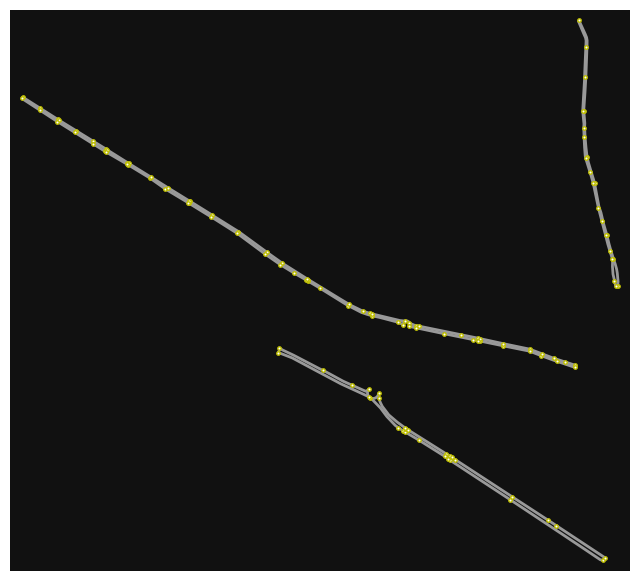

In [29]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Deshbandhu Gupta Road', 'Panchkuian Road', 'Qutab Road']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [30]:
# Repeat for  Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325755, 913325871, 560828652, 7469479279, 560828656, 9870111167, 3268564867, 560829403, 9901014823, 9599937427, 9901014824, 1809842443, 560829715, 7471269535, 1809842485, 560829526, 10310120579, 6769209407, 6384951309, 2702568911, 2702568907, 561316947, 6538800337, 1588306438, 6538800360, 6538800349, 7469479189, 1588306433, 7469479195, 7469479228, 1588306424, 1588306412, 7469479229, 7469479243, 566395083, 9874106971, 1588306383, 561316941, 9179112328, 9874317374, 9179118828, 561316938, 291542741, 9874048009, 2714430457, 938409716, 1

In [ ]:
# from collections import Counter

# # List to store road names from shortest paths
# road_names = []

# # Iterate over all pairs of location nodes
# for orig_name, orig_node in location_nodes.items():
#     for dest_name, dest_node in location_nodes.items():
#         if orig_name != dest_name:  # Avoid calculating paths from a node to itself
#             # Calculate the shortest path between the current pair of nodes
#             path = nx.shortest_path(G, orig_node, dest_node, weight='length')
#             # Extract road names from the path
#             path_edges = zip(path[:-1], path[1:])
#             path_road_names = [G.edges[u, v, 0]['name'] for u, v in path_edges if 'name' in G.edges[u, v, 0]]
#             road_names.extend(path_road_names)

# # Convert the list of road names to a tuple
# road_names_tuple = tuple(str(name) for name in road_names)

# # Count the occurrences of each road name
# road_name_counts = Counter(road_names_tuple)

# # Find the major road names
# # major_road_names = [name for name, count in road_name_counts.items() if count > 1]

# # Find the major road names and their counts
# major_road_counts = road_name_counts.most_common(5)

# # Print the most common road names and their counts
# for i, (road, count) in enumerate(major_road_counts, start=1):
#     print(f"The {i}{'st' if i == 1 else 'nd' if i == 2 else 'rd' if i == 3 else 'th' if i == 4 else 't'} most common road: '{road}' (encountered {count} times)")


# print("Major road names frequently taken in shortest paths between location pairs:")
# for name in major_road_names:
#     print(name)


Number of edges corresponding to road filter: 536


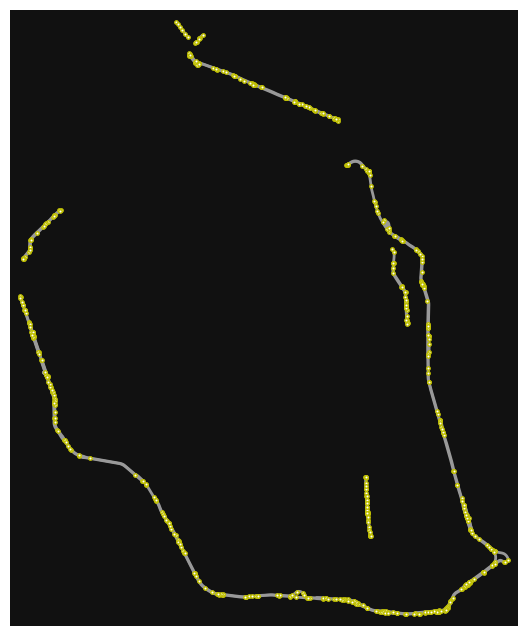

In [31]:
# Create a copy of the original graph
G_filtered = G.copy()

# List of road names to filter
road_names = ['Mahatma Gandhi Marg', 'Netaji Subhash Marg', 'Maharishi Raman Marg']

# Filter edges belonging to the specified roads
filtered_edges = gdf_edges[gdf_edges['name'].isin(road_names)]

# Get the number of edges corresponding to the filtered road
num_filtered_edges = len(filtered_edges)

# Print the number of edges corresponding to the filtered road
print(f"Number of edges corresponding to road filter: {num_filtered_edges}")

# Extract 'u' and 'v' values from the MultiIndex
u_values = filtered_edges.index.get_level_values('u')
v_values = filtered_edges.index.get_level_values('v')

# Get nodes associated with the filtered edges
filtered_nodes = set(u_values).union(set(v_values))

# Create a subgraph containing only the filtered nodes and edges
filtered_graph = G.subgraph(filtered_nodes)

# Plot the filtered graph
fig, ax = ox.plot_graph(filtered_graph, node_color='w', node_edgecolor='y', node_size=6, edge_linewidth=2)

In [32]:
# Repeat for  Road

# Filter edges belonging to the specified roads
filtered_edges = [(u, v) for u, v, key, data in G_filtered.edges(keys=True, data=True) if 'name' in data and data['name'] in road_names]

# Remove edges corresponding to the filtered road
G_filtered.remove_edges_from(filtered_edges)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Find the shortest paths between each pair of nodes and store them
shortest_paths = {}
distances = {}
for orig_name, orig_coords in locations.items():
    orig_node = ox.distance.nearest_nodes(G_filtered, orig_coords[1], orig_coords[0])
    for dest_name, dest_coords in locations.items():
        dest_node = ox.distance.nearest_nodes(G_filtered, dest_coords[1], dest_coords[0])
        if orig_name != dest_name and (orig_name, dest_name) not in shortest_paths:
            route = ox.shortest_path(G_filtered, orig_node, dest_node, weight="length")
            if route is not None:
                shortest_paths[(orig_name, dest_name)] = route
                distances[(orig_name, dest_name)] = sum(ox.distance.great_circle(G_filtered.nodes[u]['y'], G_filtered.nodes[u]['x'], G_filtered.nodes[v]['y'], G_filtered.nodes[v]['x']) for u, v in zip(route[:-1], route[1:]))

# Print the shortest paths and distances
for (orig_name, dest_name), route in shortest_paths.items():
    print(f"Shortest path from {orig_name} to {dest_name}: {route}")
    print(f"Distance: {distances[(orig_name, dest_name)]} meters\n")

# Calculate and print the sum of distances
beta = sum(distances.values())
print(f"Sum of distances: {beta} meters")

# Calculate the Road Vulnerability Index (RVI)
RVI = (beta - alpha) / alpha * 100

# Print the Edge Vulnerability Index
print(f"Road Vulnerability Index (RVI): {RVI} %")

Shortest path from Delhi University to AIIMS Hospital: [2945828443, 2945828442, 2945827921, 2939969321, 2945827905, 9840505818, 2111354713, 9840458524, 249237060, 9840591537, 10288941392, 2111354742, 11064256332, 1645501116, 2977840796, 1645501084, 10288941390, 9869489559, 2507991839, 10281669256, 1645501037, 6660061362, 943749128, 943749125, 5796662774, 943748946, 943749158, 943749372, 4231714020, 943749140, 9803633764, 1812141936, 913325716, 913325602, 913325772, 3268564811, 3268564803, 3268564807, 3268564792, 3268564802, 3268565113, 3268565064, 3268564931, 3268564883, 1809842399, 1809842350, 569682636, 9874283575, 9874283576, 9874283578, 6965577683, 6660061357, 6965638587, 9037313900, 458640663, 5638613639, 458640665, 308723081, 938409719, 308722765, 7048416704, 395135138, 458640642, 6439021689, 9860744485, 6439021690, 5681321306, 5681296954, 9880451646, 249783257, 1869716916, 267247460, 939091123, 1869716862, 3744502776, 1309626482, 249783291, 5681450581, 5681450601, 5809063022, 56